In [2]:
import sys
import numpy as np
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
import re 
import nltk
from nltk.corpus import stopwords,wordnet
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer,SnowballStemmer
from nltk import word_tokenize,sent_tokenize,pos_tag
from nltk.tokenize import RegexpTokenizer
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split,GridSearchCV,RandomizedSearchCV,StratifiedKFold,cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report
from imblearn.under_sampling import RandomUnderSampler,TomekLinks,NearMiss
from imblearn.over_sampling import RandomOverSampler,SMOTE
from sklearn.dummy import DummyClassifier
import tensorflow as tf
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from gensim.models import Word2Vec
from gensim.models.keyedvectors import KeyedVectors
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras import utils
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dropout,Dense,Activation,Lambda,LSTM,SimpleRNN,GRU,Embedding,Conv1D
from tensorflow.keras.preprocessing.text import Tokenizer
from collections import defaultdict
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import EarlyStopping

import warnings
warnings.filterwarnings('ignore')
warnings.filterwarnings('ignore',category=DeprecationWarning)
print('All libraries loaded.')

All libraries loaded.


In [3]:
train_df = pd.read_csv(r'Ecommerce\train_data.csv')
test_df = pd.read_csv(r'Ecommerce\test_data_hidden.csv')

In [4]:
print('Shape of training data:',train_df.shape)
print('Shape of testing data:',test_df.shape)

Shape of training data: (4000, 8)
Shape of testing data: (1000, 8)


In [5]:
train_df.head()

,name,brand,categories,primaryCategories,reviews.date,reviews.text,reviews.title,sentiment
0,"All-New Fire HD 8 Tablet, 8"" HD Display, Wi-Fi...",Amazon,"Electronics,iPad & Tablets,All Tablets,Fire Ta...",Electronics,2016-12-26T00:00:00.000Z,Purchased on Black FridayPros - Great Price (e...,Powerful tablet,Positive
1,Amazon - Echo Plus w/ Built-In Hub - Silver,Amazon,"Amazon Echo,Smart Home,Networking,Home & Tools...","Electronics,Hardware",2018-01-17T00:00:00.000Z,I purchased two Amazon in Echo Plus and two do...,Amazon Echo Plus AWESOME,Positive
2,Amazon Echo Show Alexa-enabled Bluetooth Speak...,Amazon,"Amazon Echo,Virtual Assistant Speakers,Electro...","Electronics,Hardware",2017-12-20T00:00:00.000Z,Just an average Alexa option. Does show a few ...,Average,Neutral
3,"Fire HD 10 Tablet, 10.1 HD Display, Wi-Fi, 16 ...",Amazon,"eBook Readers,Fire Tablets,Electronics Feature...","Office Supplies,Electronics",2017-08-04T00:00:00.000Z,"very good product. Exactly what I wanted, and ...",Greattttttt,Positive
4,"Brand New Amazon Kindle Fire 16gb 7"" Ips Displ...",Amazon,"Computers/Tablets & Networking,Tablets & eBook...",Electronics,2017-01-23T00:00:00.000Z,This is the 3rd one I've purchased. I've bough...,Very durable!,Positive


In [6]:
train_df.loc[train_df['sentiment']=='Positive','reviews.text':][:5]

,reviews.text,reviews.title,sentiment
0,Purchased on Black FridayPros - Great Price (e...,Powerful tablet,Positive
1,I purchased two Amazon in Echo Plus and two do...,Amazon Echo Plus AWESOME,Positive
3,"very good product. Exactly what I wanted, and ...",Greattttttt,Positive
4,This is the 3rd one I've purchased. I've bough...,Very durable!,Positive
5,This is a great product. Light weight. I wish ...,You will love it,Positive


In [7]:
train_df.loc[train_df['sentiment']=='Neutral','reviews.text':][:5]

,reviews.text,reviews.title,sentiment
2,Just an average Alexa option. Does show a few ...,Average,Neutral
6,My 7-year old daughter saved up to by this. He...,OK For Entry Level Tablet,Neutral
17,"Not as good as before the old kindle, just sea...",Not as good as before,Neutral
59,There is nothing spectacular about this item b...,"Does what it says, missing one key feature",Neutral
95,It's unfair for me to rate this product cause ...,Haven't set it up yet,Neutral


In [8]:
train_df.loc[train_df['sentiment']=='Negative','reviews.text':][:5]

,reviews.text,reviews.title,sentiment
9,"was cheap, can not run chrome stuff, returned ...","was cheap, can not run chrome stuff, returned",Negative
97,"Worthless, except as a regular echo and a poor...",Useless screen so why pay for it?,Negative
104,Too bad Amazon turned this tablet into a big a...,Amazon Fire 7 Tablet,Negative
121,I bought this Kindle for my 7 year old grand-d...,Kid's Kindle,Negative
150,I am reading positive reviews and wish I could...,Have never purchased a more frustrating Device,Negative


In [9]:
train_df.sentiment.value_counts()

Positive    3749
Neutral      158
Negative      93
Name: sentiment, dtype: int64

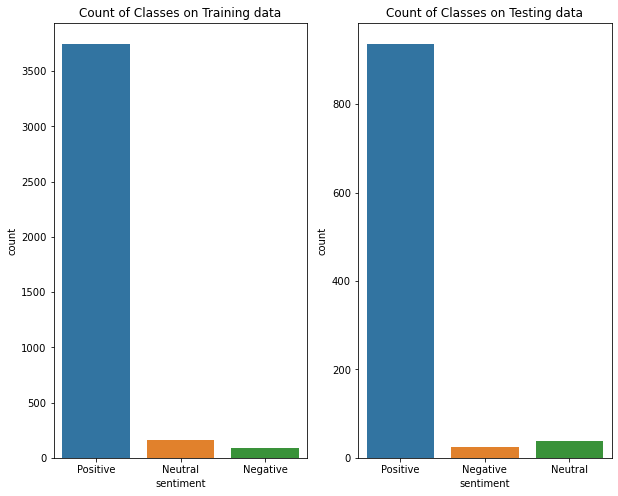

In [10]:
plt.figure(figsize=(10,8))
plt.subplot(1,2,1)
plt.title('Count of Classes on Training data')
sns.countplot(x='sentiment',data=train_df)
plt.subplot(1,2,2)
plt.title('Count of Classes on Testing data')
sns.countplot(x='sentiment',data=test_df)
plt.show()

It is evident that this is a clear case of class imbalance

In [11]:
stopwords = set(stopwords.words('english'))
wordnet_lem = WordNetLemmatizer()
tokenizer = RegexpTokenizer(r'[a-z]+')

def text_preprocess(doc):
    doc = doc.lower()
    words = tokenizer.tokenize(doc)
    words = [word for word in words if word not in stopwords]
    for pos in [wordnet.NOUN,wordnet.VERB,wordnet.ADJ,wordnet.ADV]:
        words = [wordnet_lem.lemmatize(x,pos) for x in words]
    return ' '.join(words)

In [12]:
train_data = train_df[['sentiment','reviews.text']]
test_data = test_df[['sentiment','reviews.text']]
train_data.head()

,sentiment,reviews.text
0,Positive,Purchased on Black FridayPros - Great Price (e...
1,Positive,I purchased two Amazon in Echo Plus and two do...
2,Neutral,Just an average Alexa option. Does show a few ...
3,Positive,"very good product. Exactly what I wanted, and ..."
4,Positive,This is the 3rd one I've purchased. I've bough...


In [13]:
train_data['preprocessed_reviews'] = train_data['reviews.text'].apply(text_preprocess)
test_data['preprocessed_reviews'] = test_data['reviews.text'].apply(text_preprocess)
train_data.head()

,sentiment,reviews.text,preprocessed_reviews
0,Positive,Purchased on Black FridayPros - Great Price (e...,purchase black fridaypros great price even sal...
1,Positive,I purchased two Amazon in Echo Plus and two do...,purchase two amazon echo plus two dot plus fou...
2,Neutral,Just an average Alexa option. Does show a few ...,average alexa option show thing screen still l...
3,Positive,"very good product. Exactly what I wanted, and ...",good product exactly want good price
4,Positive,This is the 3rd one I've purchased. I've bough...,rd one purchase buy one niece case compare one...


In [14]:
train_data = train_data[['sentiment','preprocessed_reviews']]
test_data = test_data[['sentiment','preprocessed_reviews']]

train_data.head()

,sentiment,preprocessed_reviews
0,Positive,purchase black fridaypros great price even sal...
1,Positive,purchase two amazon echo plus two dot plus fou...
2,Neutral,average alexa option show thing screen still l...
3,Positive,good product exactly want good price
4,Positive,rd one purchase buy one niece case compare one...


In [15]:
count_vec = CountVectorizer()
bow = count_vec.fit(train_data['preprocessed_reviews'])
len(bow.vocabulary_)

3397

In [16]:
reviews_bow = bow.transform(train_data['preprocessed_reviews'])
reviews_bow

<4000x3397 sparse matrix of type '<class 'numpy.int64'>'
	with 54104 stored elements in Compressed Sparse Row format>

In [17]:
cv = TfidfVectorizer()
tfidf_final = cv.fit_transform(train_data['preprocessed_reviews']).toarray()

In [18]:
tfidf_final.shape

(4000, 3397)

In [19]:
kfold = StratifiedKFold(n_splits=5)
model_nb = MultinomialNB()
scores = cross_val_score(estimator=model_nb,X=tfidf_final,y=train_data['sentiment'],cv=kfold)
avg_val_score = scores.mean()
print('Average validation accuracy:',avg_val_score)

Average validation accuracy: 0.93725


In [20]:
test = 'it was very bad and nothing is good'
model_nb.fit(tfidf_final,train_data['sentiment'])
a1 = text_preprocess(test)
a2 = cv.transform(list(a1))
prediction = model_nb.predict(a2[0])
prediction

array(['Positive'], dtype='<U8')

The model has predicted all classes as positive due to class imbalance problem.
To solve this problem we will be performing some over-sampling techniques.

In [21]:
X = train_data[['preprocessed_reviews']]
y = train_data['sentiment']

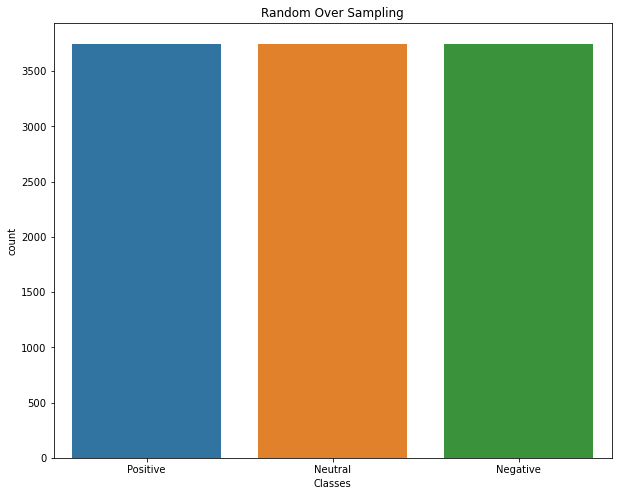

In [22]:
plt.figure(figsize=(10,8))
ros = RandomOverSampler(random_state=42)
x_ros,y_ros = ros.fit_resample(X,y)
sns.countplot(x=y_ros)
plt.title("Random Over Sampling")
plt.xlabel("Classes")
plt.show()

In [23]:
print('Shape of new training data:',x_ros.shape)

Shape of new training data: (11247, 1)


In [24]:
from collections import Counter
Counter(y_ros).items()

dict_items([('Positive', 3749), ('Neutral', 3749), ('Negative', 3749)])

In [25]:
train_df = pd.concat((x_ros['preprocessed_reviews'],y_ros),ignore_index=True,axis=1)
train_df.columns = ['preprocessed_reviews','sentiment']
train_df.head()

,preprocessed_reviews,sentiment
0,purchase black fridaypros great price even sal...,Positive
1,purchase two amazon echo plus two dot plus fou...,Positive
2,average alexa option show thing screen still l...,Neutral
3,good product exactly want good price,Positive
4,rd one purchase buy one niece case compare one...,Positive


In [26]:
train_df_final = train_df.sample(frac=0.1,random_state=0)
train_df_final.dropna(inplace=True)
train_df_final.head()

,preprocessed_reviews,sentiment
8805,tablet great book audible book music thing ama...,Neutral
9736,work fine wifi otherwise little slow kid enjoy...,Neutral
125,item work expect great product,Positive
10143,nothing spectacular item also nothing majorly ...,Neutral
10937,dollar great option although black friday spec...,Neutral


In [27]:
x_train,x_val,y_train,y_val = train_test_split(train_df_final['preprocessed_reviews'],train_df_final.sentiment,test_size=0.1,random_state=0)
print('Shape of training and validation data:',(x_train.shape,x_val.shape))

Shape of training and validation data: ((1012,), (113,))


CountVectorizer + MultinomialNB 

In [28]:
cv = CountVectorizer()
x_train_vec = cv.fit_transform(x_train)
feature_names = cv.get_feature_names()
print('Number of features:',len(feature_names))
print('Some of the features are:',np.random.choice(feature_names,size=5))

mnb = MultinomialNB()
mnb.fit(x_train_vec,y_train)

Number of features: 1505
Some of the features are: ['associate' 'kid' 'bt' 'display' 'learn']


MultinomialNB()

In [29]:
def plot_conf_matrix(y_val,predictions):
    conf_matrix = confusion_matrix(y_val,predictions)
    sns.heatmap(conf_matrix, cmap="Blues",annot=True)
    plt.title("Confusion matrix.")
    plt.xlabel('Predicted Class')
    plt.ylabel('True Class')
    plt.show()

def model_eval(y_val,predictions):
    print('Accuracy on validation data: {:.4f}'.format(accuracy_score(y_val,predictions)))
    print('Classification report:\n',classification_report(y_val,predictions))
    plot_conf_matrix(y_val,predictions)
    

Accuracy on validation data: 0.8673
Classification report:
               precision    recall  f1-score   support

    Negative       0.93      0.95      0.94        39
     Neutral       0.86      0.79      0.83        39
    Positive       0.81      0.86      0.83        35

    accuracy                           0.87       113
   macro avg       0.87      0.87      0.87       113
weighted avg       0.87      0.87      0.87       113



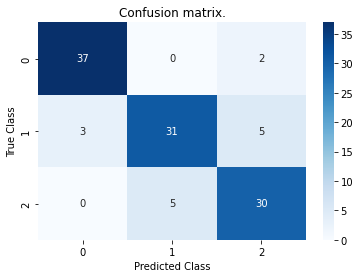

In [30]:
pred = mnb.predict(cv.transform(x_val))
model_eval(y_val,pred)

Tfidf + LogisticRegression

In [31]:
from sklearn.linear_model import LogisticRegression
tfidf = TfidfVectorizer(min_df=5)
x_train_tfidf = tfidf.fit_transform(x_train)
feature_names = tfidf.get_feature_names()
print('Number of features:',len(feature_names))
print('Some of the features are:',np.random.choice(feature_names,size=5))

lr = LogisticRegression()
lr.fit(x_train_tfidf,y_train)

Number of features: 694
Some of the features are: ['weather' 'car' 'safe' 'every' 'bestbuy']


LogisticRegression()

In [32]:
sorted_coef_i = lr.coef_[0].argsort().astype(int)
features_array = np.array(feature_names)
print('\nTop 10 features with smallest coefficients for negative class:{}'.format(features_array[sorted_coef_i[:10]]))
print('\nTop 10 features with largest coefficients for negative class:{}'.format(features_array[sorted_coef_i[-11:-1]]))


Top 10 features with smallest coefficients for negative class:['love' 'great' 'easy' 'read' 'play' 'ok' 'price' 'alexa' 'well' 'enjoy']

Top 10 features with largest coefficients for negative class:['program' 'try' 'poor' 'minute' 'terrible' 'generation' 'useless' 'th'
 'update' 'bad']


Accuracy on validation data: 0.8673
Classification report:
               precision    recall  f1-score   support

    Negative       0.93      0.95      0.94        39
     Neutral       0.86      0.82      0.84        39
    Positive       0.81      0.83      0.82        35

    accuracy                           0.87       113
   macro avg       0.87      0.87      0.87       113
weighted avg       0.87      0.87      0.87       113



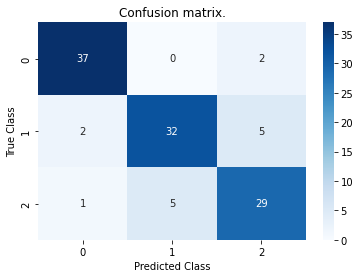

In [33]:
pred = lr.predict(tfidf.transform(x_val))
model_eval(y_val,pred)

TfidfVectorizer with Linear SVM by using SGD

In [34]:
from sklearn.linear_model import SGDClassifier
x_train_tfidf = tfidf.fit_transform(x_train)
feature_names = tfidf.get_feature_names()
print('Number of features:',len(feature_names))
print('Some of the features are:',np.random.choice(feature_names,size=5))

sgd_clf = SGDClassifier(loss='hinge',penalty='l2')
sgd_clf.fit(x_train_tfidf,y_train)

Number of features: 694
Some of the features are: ['present' 'avid' 'price' 'tot' 'think']


SGDClassifier()

In [35]:
sorted_coef_i = sgd_clf.coef_[0].argsort()
features_array = np.array(feature_names)
print('\nTop 10 features with smallest coefficients for negative class:{}'.format(features_array[sorted_coef_i[:10]]))
print('\nTop 10 features with largest coefficients for negative class:{}'.format(features_array[sorted_coef_i[-11:-1]]))


Top 10 features with smallest coefficients for negative class:['overall' 'play' 'control' 'love' 'great' 'easy' 'sometimes' 'unit'
 'well' 'look']

Top 10 features with largest coefficients for negative class:['friendly' 'customer' 'terrible' 'useless' 'never' 'th' 'update' 'bad'
 'exchange' 'minute']


Accuracy on validation data: 0.8407
Classification report:
               precision    recall  f1-score   support

    Negative       0.93      0.95      0.94        39
     Neutral       0.79      0.85      0.81        39
    Positive       0.81      0.71      0.76        35

    accuracy                           0.84       113
   macro avg       0.84      0.84      0.84       113
weighted avg       0.84      0.84      0.84       113



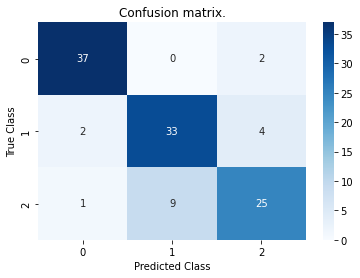

In [36]:
pred = sgd_clf.predict(tfidf.transform(x_val))
model_eval(y_val,pred)

Using XgBoost with tfidf

In [37]:
x_train_tfidf = tfidf.fit_transform(x_train)
feature_names = tfidf.get_feature_names()
print('Number of features:',len(feature_names))
print('Some of the features are:',np.random.choice(feature_names,size=5))

xgb = XGBClassifier()
xgb.fit(x_train_tfidf,y_train)

Number of features: 694
Some of the features are: ['week' 'october' 'recharge' 'kid' 'plus']
[14:01:10] WARNING: ..\src\learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=8, num_parallel_tree=1,
              objective='multi:softprob', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=None, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [38]:
sorted_coef_i = xgb.feature_importances_.argsort()
features_array = np.array(feature_names)
print('\nTop 10 features with smallest importance:{}'.format(features_array[sorted_coef_i[:10]]))
print('\nTop 10 features with largest importance:{}'.format(features_array[sorted_coef_i[-11:-1]]))


Top 10 features with smallest importance:['yr' 'ride' 'kitchen' 'right' 'ring' 'run' 'safe' 'junk' 'sake' 'sale']

Top 10 features with largest importance:['seem' 'design' 'useless' 'long' 'change' 'dot' 'ok' 'love' 'hour'
 'paper']


Accuracy on validation data: 0.9027
Classification report:
               precision    recall  f1-score   support

    Negative       0.97      0.95      0.96        39
     Neutral       0.92      0.87      0.89        39
    Positive       0.82      0.89      0.85        35

    accuracy                           0.90       113
   macro avg       0.90      0.90      0.90       113
weighted avg       0.91      0.90      0.90       113



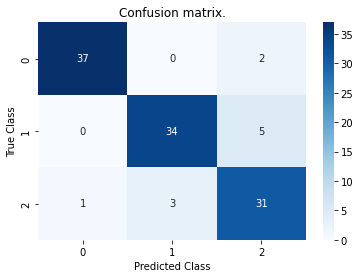

In [39]:
pred = xgb.predict(tfidf.transform(x_val))
model_eval(y_val,pred)

Pipeline+GridSearch

In [189]:
estimators =  [('tfidf',TfidfVectorizer()),('xgb',XGBClassifier())]
pipeline = Pipeline(estimators)

params = {'xgb__n_estimators':[50,100,200],
          'xgb__max_depth':[2,5,10],
          'xgb__learning_rate':[0.01,0.03,0.1],
          'tfidf__min_df':[1,3,5],
          'tfidf__max_features':[1000,None],
          'tfidf__ngram_range':[(1,1),(1,2)]}

grid = GridSearchCV(estimator=pipeline,param_grid=params,n_jobs=-1,scoring='accuracy')
grid.fit(x_train,y_train)

[01:41:38] WARNING: ..\src\learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


GridSearchCV(estimator=Pipeline(steps=[('tfidf', TfidfVectorizer()),
                                       ('xgb',
                                        XGBClassifier(base_score=None,
                                                      booster=None,
                                                      colsample_bylevel=None,
                                                      colsample_bynode=None,
                                                      colsample_bytree=None,
                                                      gamma=None, gpu_id=None,
                                                      importance_type='gain',
                                                      interaction_constraints=None,
                                                      learning_rate=None,
                                                      max_delta_step=None,
                                                      max_depth=None,
                                                     

In [193]:
print('Best parameters:',grid.best_params_)

Best parameters: {'tfidf__max_features': None, 'tfidf__min_df': 3, 'tfidf__ngram_range': (1, 2), 'xgb__learning_rate': 0.1, 'xgb__max_depth': 10, 'xgb__n_estimators': 200}


Accuracy on validation data: 0.8850
Classification report:
               precision    recall  f1-score   support

    Negative       0.97      0.95      0.96        39
     Neutral       0.89      0.85      0.87        39
    Positive       0.79      0.86      0.82        35

    accuracy                           0.88       113
   macro avg       0.89      0.88      0.88       113
weighted avg       0.89      0.88      0.89       113



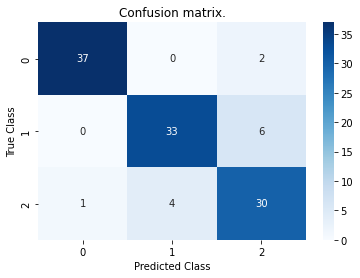

In [196]:
pred = grid.predict(x_val)
model_eval(y_val,pred)

Word2Vec+RandomForest

In [97]:
def sentence_parser(reviews):
    a = []
    for sent in reviews:
        a.append(word_tokenize(sent))
    return a

sentences = sentence_parser(x_train)
# Setting paraameters
num_features = 300
min_word_count = 5
num_workers = 4
context = 10
downsampling = 1e-3

model_w2v = Word2Vec(sentences,
                     workers=num_workers,
                     vector_size=num_features,
                     min_count=min_word_count,
                     window=context,
                     sample=downsampling)
model_w2v.init_sims(replace=True)
model_w2v.save('w2v_model')

print('No. of words in vocabulary list:{}\n'.format(len(model_w2v.wv.index_to_key)))
print('First 10 words in vocabulary list{}\n'.format(model_w2v.wv.index_to_key[:10]))

No. of words in vocabulary list:706

First 10 words in vocabulary list['tablet', 'use', 'buy', 'good', 'great', 'work', 'amazon', 'get', 'one', 'kindle']



In [105]:
def create_feature_vec(review,num_features,model):
    feature_vec = np.zeros(shape=(num_features,),dtype='float32')
    nwords = 0
    n_words = 0
    word_set = set(model.wv.index_to_key)
    zero_vec = True
    for word in review:
        if word in word_set:
            n_words = n_words + 1
            feature_vec = feature_vec + model.wv[word]
            zero_vec = False
    if zero_vec==False:
        zero_vec = feature_vec/n_words
    return feature_vec

def get_avg_feature_vec(reviews,model,num_features):
    i = 0
    avg_featuresVec = np.zeros(shape=(len(reviews),num_features),dtype='float32')
    for review in reviews:
        avg_featuresVec[i] = create_feature_vec(review,num_features,model)
        i = i + 1
    return avg_featuresVec

In [106]:
train_vector = get_avg_feature_vec(x_train,model_w2v,num_features)
print('Training set: %d feature vectors with %d dimensions'%train_vector.shape)

val_vector = get_avg_feature_vec(x_val,model_w2v,num_features)
print('Validation set: %d feature vectors with %d dimensions'%val_vector.shape)

Training set: 1012 feature vectors with 300 dimensions
Validation set: 113 feature vectors with 300 dimensions


Accuracy on validation data: 0.5841
Classification report:
               precision    recall  f1-score   support

    Negative       0.69      0.69      0.69        39
     Neutral       0.54      0.67      0.60        39
    Positive       0.50      0.37      0.43        35

    accuracy                           0.58       113
   macro avg       0.58      0.58      0.57       113
weighted avg       0.58      0.58      0.58       113



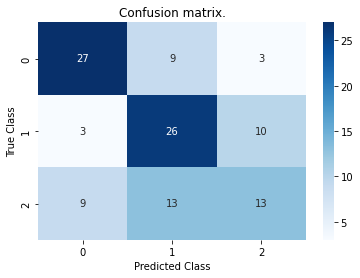

In [107]:
rf = RandomForestClassifier(n_estimators=100)
rf.fit(train_vector,y_train)
pred = rf.predict(val_vector)
model_eval(y_val,pred)

Using deep learning techniques

In [114]:
top_words = 20000
maxlen = 100
batch_size = 20
nb_classes = 3
nb_epoch = 12

tokenizer = Tokenizer(num_words=top_words)
tokenizer.fit_on_texts(x_train)

sequences_train = tokenizer.texts_to_sequences(x_train)
sequences_val = tokenizer.texts_to_sequences(x_val)

x_train_seq = sequence.pad_sequences(sequences_train,maxlen=maxlen)
x_val_seq = sequence.pad_sequences(sequences_val,maxlen=maxlen)

le = LabelEncoder()
y_train_seq = utils.to_categorical(le.fit_transform(y_train),nb_classes)
y_val_seq = utils.to_categorical(le.transform(y_val),nb_classes)

print('x_train shape:',x_train_seq.shape)
print('x_val shape:',x_val_seq.shape)
print('y_train shape:',y_train_seq.shape)
print('y_val shape:',y_val_seq.shape)

x_train shape: (1012, 100)
x_val shape: (113, 100)
y_train shape: (1012, 3)
y_val shape: (113, 3)


In [116]:
model_1 = Sequential()
model_1.add(Embedding(top_words,128))
model_1.add(Dropout(0.4))
model_1.add(LSTM(128))
model_1.add(Dense(nb_classes,activation='softmax'))
model_1.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 128)         2560000   
_________________________________________________________________
dropout_1 (Dropout)          (None, None, 128)         0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 128)               131584    
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 387       
Total params: 2,691,971
Trainable params: 2,691,971
Non-trainable params: 0
_________________________________________________________________


In [117]:
model_1.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])
history = model_1.fit(x_train_seq,y_train_seq,
            batch_size=batch_size,
            validation_data=(x_val_seq,y_val_seq),
            epochs=nb_epoch)

Epoch 1/12
51/51 [==============================] - 10s 129ms/step - loss: 1.0345 - accuracy: 0.5138 - val_loss: 0.7900 - val_accuracy: 0.7522
Epoch 2/12
51/51 [==============================] - 5s 95ms/step - loss: 0.5173 - accuracy: 0.8192 - val_loss: 0.4044 - val_accuracy: 0.8407
Epoch 3/12
51/51 [==============================] - 5s 96ms/step - loss: 0.2105 - accuracy: 0.9318 - val_loss: 0.4450 - val_accuracy: 0.8584
Epoch 4/12
51/51 [==============================] - 5s 105ms/step - loss: 0.1539 - accuracy: 0.9595 - val_loss: 0.3861 - val_accuracy: 0.8673
Epoch 5/12
51/51 [==============================] - 5s 99ms/step - loss: 0.0593 - accuracy: 0.9881 - val_loss: 0.3844 - val_accuracy: 0.8938
Epoch 6/12
51/51 [==============================] - 6s 114ms/step - loss: 0.0423 - accuracy: 0.9872 - val_loss: 0.4455 - val_accuracy: 0.8850
Epoch 7/12
51/51 [==============================] - 5s 103ms/step - loss: 0.0151 - accuracy: 0.9990 - val_loss: 0.4582 - val_accuracy: 0.8938
Epoch 8/

In [118]:
def model_training(history):
  plt.figure(figsize=(20,8))
  plt.subplot(1,2,1)
  plt.plot(history.history['loss'],color='r',label='Training Loss')
  plt.plot(history.history['val_loss'],color='g',label='Validation Loss')
  plt.xlabel('epochs')
  plt.ylabel('Loss')
  plt.legend()
  plt.title('Loss',color='orange')
  plt.subplot(1,2,2)
  plt.plot(history.history['accuracy'],color='r',label='Training Accuracy')
  plt.plot(history.history['val_accuracy'],color='g',label='Validation Accuracy')
  plt.xlabel('epochs')
  plt.ylabel('Accuracy')
  plt.title('Accuracy',color='orange')
  plt.legend()
  plt.show()

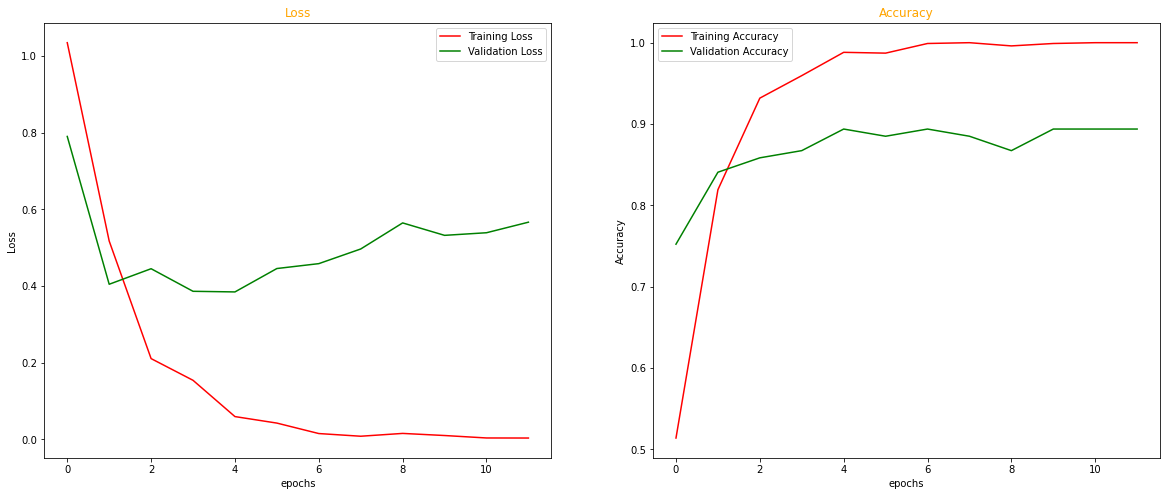

In [119]:
model_training(history)

In [121]:
metrics = model_1.evaluate(x_val_seq,y_val_seq,batch_size=batch_size,verbose=0)
print('Test loss:',metrics[0])
print('Test accuracy,',metrics[1])

Test loss: 0.5663489699363708
Test accuracy, 0.8938053250312805


In [127]:
model_1.layers[0].get_weights()[0]


array([[-0.00280707, -0.00909205,  0.00539963, ...,  0.01141004,
         0.00398173,  0.01346572],
       [-0.00514027, -0.04962541, -0.01099043, ...,  0.02675252,
        -0.03046135, -0.03544153],
       [-0.01353901, -0.01130819, -0.00434166, ..., -0.08324616,
         0.06148088, -0.05254243],
       ...,
       [-0.03311042, -0.03086486, -0.01243066, ...,  0.01714103,
        -0.01411345,  0.03667352],
       [ 0.04003402, -0.04165492, -0.00584479, ...,  0.02353313,
         0.02402849, -0.04189087],
       [ 0.02599695, -0.02424543,  0.04559637, ..., -0.03727194,
        -0.01068642,  0.02681093]], dtype=float32)

LSTM+Word2Vec

In [138]:
w2v = Word2Vec.load('w2v_model')
vocab = w2v.wv.index_to_key
embedding_matrix = w2v.wv[vocab]
print('Shape of embedding matrix:',embedding_matrix.shape)

Shape of embedding matrix: (706, 300)


In [176]:
top_words = embedding_matrix.shape[0]
maxlen = 100
batch_size = 32
nb_classes = 3
nb_epoch = 10

tokenizer = Tokenizer(num_words=top_words)
tokenizer.fit_on_texts(x_train)

sequences_train = tokenizer.texts_to_sequences(x_train)
sequences_val = tokenizer.texts_to_sequences(x_val)

x_train_seq = sequence.pad_sequences(sequences_train,maxlen=maxlen)
x_val_seq = sequence.pad_sequences(sequences_val,maxlen=maxlen)

le = LabelEncoder()
y_train_seq = utils.to_categorical(le.fit_transform(y_train),nb_classes)
y_val_seq = utils.to_categorical(le.transform(y_val),nb_classes)

print('x_train shape:',x_train_seq.shape)
print('x_val shape:',x_val_seq.shape)
print('y_train shape:',y_train_seq.shape)
print('y_val shape:',y_val_seq.shape)

x_train shape: (1012, 100)
x_val shape: (113, 100)
y_train shape: (1012, 3)
y_val shape: (113, 3)


In [178]:

embedding_layer = Embedding(input_dim=embedding_matrix.shape[0],
                            output_dim=embedding_matrix.shape[1],
                            embeddings_initializer=tf.keras.initializers.Constant(embedding_matrix))

model_2 = Sequential()
model_2.add(embedding_layer)
model_2.add(Dropout(0.4))
model_2.add(LSTM(128))
model_2.add(Dense(nb_classes,activation='softmax'))
model_2.summary()

Model: "sequential_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_20 (Embedding)     (None, None, 300)         211800    
_________________________________________________________________
dropout_15 (Dropout)         (None, None, 300)         0         
_________________________________________________________________
lstm_15 (LSTM)               (None, 128)               219648    
_________________________________________________________________
dense_15 (Dense)             (None, 3)                 387       
Total params: 431,835
Trainable params: 431,835
Non-trainable params: 0
_________________________________________________________________


In [179]:
model_2.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])
history = model_2.fit(x_train_seq,y_train_seq,
                      batch_size=batch_size,
                      validation_data=(x_val_seq,y_val_seq),
                      epochs=nb_epoch)

Epoch 1/10
32/32 [==============================] - 13s 295ms/step - loss: 1.0783 - accuracy: 0.4664 - val_loss: 1.0039 - val_accuracy: 0.5841
Epoch 2/10
32/32 [==============================] - 5s 150ms/step - loss: 0.7089 - accuracy: 0.7292 - val_loss: 0.5147 - val_accuracy: 0.8142
Epoch 3/10
32/32 [==============================] - 5s 146ms/step - loss: 0.2811 - accuracy: 0.8933 - val_loss: 0.4788 - val_accuracy: 0.8407
Epoch 4/10
32/32 [==============================] - 5s 152ms/step - loss: 0.1724 - accuracy: 0.9387 - val_loss: 0.5098 - val_accuracy: 0.8407
Epoch 5/10
32/32 [==============================] - 5s 153ms/step - loss: 0.1105 - accuracy: 0.9625 - val_loss: 0.5195 - val_accuracy: 0.8673
Epoch 6/10
32/32 [==============================] - 5s 155ms/step - loss: 0.0765 - accuracy: 0.9792 - val_loss: 0.5343 - val_accuracy: 0.8850
Epoch 7/10
32/32 [==============================] - 5s 152ms/step - loss: 0.0474 - accuracy: 0.9872 - val_loss: 0.5593 - val_accuracy: 0.8938
Epoch

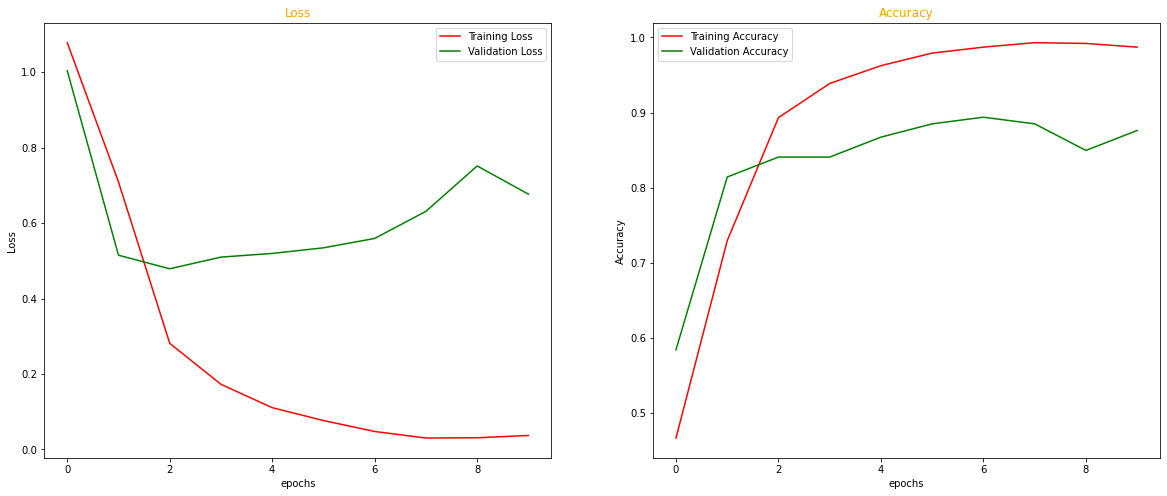

Test loss: 0.6767473220825195
Test accuracy, 0.8761062026023865


In [180]:
model_training(history)
metrics = model_2.evaluate(x_val_seq,y_val_seq,batch_size=batch_size,verbose=0)
print('Test loss:',metrics[0])
print('Test accuracy,',metrics[1])

# Topic Modelling

In [43]:
from gensim.models.ldamodel import LdaModel
from gensim import corpora
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
import spacy

In [60]:
document = train_data['preprocessed_reviews'].to_list()
doc = [doc.split() for doc in document]
id2word = corpora.Dictionary(doc)

print(id2word)

Dictionary(3415 unique tokens: ['able', 'access', 'accomplish', 'ad', 'add']...)


In [69]:
corpus = [id2word.doc2bow(text) for text in doc]
corpus[5][:20]

[(16, 1), (93, 1), (104, 1), (105, 1), (106, 1), (107, 1), (108, 1), (109, 1)]

In [72]:
lda = LdaModel(corpus,
               num_topics=9,
               id2word=id2word,
               passes=30)

In [83]:
topics = lda.show_topics()
print('Number of topics:{}\n'.format(len(topics)))
print('Topics')
for topic in topics:
    print(topic)

Number of topics:9

Topics
(0, '0.076*"buy" + 0.049*"one" + 0.035*"love" + 0.033*"gift" + 0.031*"get" + 0.021*"christmas" + 0.019*"best" + 0.017*"wife" + 0.016*"purchase" + 0.013*"happy"')
(1, '0.083*"read" + 0.080*"book" + 0.032*"use" + 0.030*"kindle" + 0.023*"love" + 0.022*"easy" + 0.021*"reader" + 0.019*"size" + 0.014*"e" + 0.012*"great"')
(2, '0.038*"echo" + 0.025*"alexa" + 0.021*"show" + 0.020*"music" + 0.020*"love" + 0.018*"great" + 0.015*"sound" + 0.014*"home" + 0.013*"use" + 0.013*"amazon"')
(3, '0.075*"great" + 0.068*"easy" + 0.067*"use" + 0.054*"product" + 0.036*"recommend" + 0.026*"set" + 0.022*"love" + 0.022*"work" + 0.021*"would" + 0.017*"good"')
(4, '0.068*"tablet" + 0.034*"good" + 0.029*"price" + 0.026*"great" + 0.024*"amazon" + 0.017*"apps" + 0.015*"use" + 0.013*"work" + 0.011*"nice" + 0.010*"fire"')
(5, '0.031*"kid" + 0.016*"like" + 0.013*"little" + 0.013*"version" + 0.010*"thing" + 0.010*"device" + 0.010*"access" + 0.010*"pretty" + 0.010*"previous" + 0.010*"amazon"')


In [85]:
word_dict = {}
for i in range(9):
    words = lda.show_topic(i,topn=20)
    word_dict['Topic-'+str(i)] = [i[0] for i in words]

words_df = pd.DataFrame(word_dict)
words_df

,Topic-0,Topic-1,Topic-2,Topic-3,Topic-4,Topic-5,Topic-6,Topic-7,Topic-8
0,buy,read,echo,great,tablet,kid,get,kindle,love
1,one,book,alexa,easy,good,like,need,light,tablet
2,love,use,show,use,price,little,one,read,old
3,gift,kindle,music,product,great,version,time,battery,year
4,get,love,love,recommend,amazon,thing,great,screen,buy
5,christmas,easy,great,set,apps,device,tablet,charge,kid
6,best,reader,sound,love,use,access,work,life,game
7,wife,size,home,work,work,pretty,price,like,play
8,purchase,e,use,would,nice,previous,well,fire,great
9,happy,great,amazon,good,fire,amazon,issue,small,purchase


In [74]:
pyLDAvis.enable_notebook()
vis = gensimvis.prepare(lda,corpus,id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2      0.060069  0.033729       1        1  24.890787
4      0.064557 -0.022378       2        1  15.396722
8      0.079615  0.075145       3        1  13.176244
7     -0.243100  0.037995       4        1  11.234406
0      0.005824 -0.089727       5        1   9.348219
3      0.181009  0.129688       6        1   8.620606
1     -0.132904  0.163153       7        1   7.097493
6      0.014514 -0.187941       8        1   6.035642
5     -0.029585 -0.139663       9        1   4.199881, topic_info=       Term         Freq        Total Category  logprob  loglift
343    read   506.000000   506.000000  Default  30.0000  30.0000
94      buy   864.000000   864.000000  Default  29.0000  29.0000
114    book   360.000000   360.000000  Default  28.0000  28.0000
33   tablet  1111.000000  1111.000000  Default  27.0000  27.0000
197    easy   691.000000   691.000000  Default  26.0000  26.0000
..      ...          ...          ...      ...      ...      ...
201     set    17.315934   279.342188   Topic9  -4.9835   0.3893
434     big    15.565143    99.702625   Topic9  -5.0901   1.3130
92     good    17.203452   750.735150   Topic9  -4.9900  -0.6058
179    love    17.240815  1251.472793   Topic9  -4.9879  -1.1147
83    would    15.998733   367.679026   Topic9  -5.0626   0.0354

[641 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
405       1  0.105790  absolutely
405       3  0.881583  absolutely
1         1  0.064740      access
1         2  0.372253      access
1         7  0.145664      access
...     ...       ...         ...
153       5  0.048067        year
153       9  0.009613        year
780       2  0.101270       young
780       3  0.877673       young
515       3  0.984565          yr

[1233 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 5, 9, 8, 1, 4, 2, 7, 6])

In [86]:
from sklearn.decomposition import NMF

In [87]:
tfidf = TfidfVectorizer()
tfidf_vectors = tfidf.fit_transform(train_data['preprocessed_reviews'])

In [88]:
clf = NMF(n_components=9)
W1 = clf.fit_transform(tfidf_vectors)
H1 = clf.components_

In [109]:
W1

array([[0.01449807, 0.00151497, 0.08581705, ..., 0.01411392, 0.        ,
        0.01939184],
       [0.07411518, 0.00711464, 0.        , ..., 0.03347694, 0.00409665,
        0.        ],
       [0.0593265 , 0.        , 0.        , ..., 0.        , 0.0008855 ,
        0.00019458],
       ...,
       [0.03763963, 0.00053826, 0.00603376, ..., 0.0038671 , 0.        ,
        0.00246975],
       [0.01060079, 0.00773378, 0.09380115, ..., 0.01490207, 0.0046367 ,
        0.0048319 ],
       [0.        , 0.        , 0.10221353, ..., 0.        , 0.        ,
        0.        ]])

In [97]:
H1

array([[0.00000000e+00, 6.68754107e-02, 2.35794727e-01, ...,
        4.13068421e-04, 0.00000000e+00, 0.00000000e+00],
       [4.94552665e-04, 6.11494567e-03, 1.27910064e-02, ...,
        0.00000000e+00, 7.11181090e-04, 0.00000000e+00],
       [4.84565186e-03, 5.91602513e-03, 1.26578591e-02, ...,
        8.55385143e-04, 2.81642341e-04, 0.00000000e+00],
       ...,
       [2.05226531e-03, 0.00000000e+00, 1.18821083e-02, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [1.21376081e-04, 1.91928177e-02, 4.47188430e-02, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [7.84909693e-03, 4.41928516e-03, 1.27333999e-02, ...,
        0.00000000e+00, 7.68100616e-03, 0.00000000e+00]])

In [106]:
vocab = np.array(tfidf.get_feature_names())
a = np.argsort(H1)
topic_words = [vocab[i] for i in a[:,-20:]]
topics = [' '.join(t) for t in topic_words]

In [107]:
topics

['thing see speaker ask like screen good light dot smart plus device video sound amazon home music show alexa echo',
 'last happy replace enjoy boy durable drop get tablet operate game buy granddaughter son yr purchase perfect grandson year old',
 'like hd look quality basic purchase size would little perfect fast apps fire child nice amazon need price good tablet',
 'even problem mom box learn day light lot really simple item navigate purchase super fun setup product set use easy',
 'make life good upgrade game device hd battery reader go much new screen size light like fire book read kindle',
 'feature life addition deal battery camera item friend value quality anyone highly sound well would recommend price work product great',
 'mom second recommend enjoy family replace give want another much happy purchase would wife best get christmas gift one buy',
 'grand much grandkids age alexa keep everything niece gift awesome nephew wife birthday purchase grandson granddaughter absolutely s

In [116]:
colnames = ['Topic'+str(i) for i in range(9)]
docnames = ['doc'+str(i) for i in range(tfidf_vectors.shape[0])]
df_doc_topic = pd.DataFrame(np.round(W1,2),columns=colnames,index=docnames)
df_doc_topic['significant_topic'] = np.argmax(df_doc_topic.values,axis=1)
df_doc_topic

,Topic0,Topic1,Topic2,Topic3,Topic4,Topic5,Topic6,Topic7,Topic8,significant_topic
doc0,0.01,0.00,0.09,0.00,0.01,0.04,0.01,0.00,0.02,2
doc1,0.07,0.01,0.00,0.01,0.01,0.00,0.03,0.00,0.00,0
doc2,0.06,0.00,0.00,0.00,0.01,0.00,0.00,0.00,0.00,0
doc3,0.01,0.00,0.14,0.00,0.01,0.06,0.00,0.00,0.00,2
doc4,0.00,0.01,0.05,0.00,0.00,0.00,0.14,0.00,0.01,6
...,...,...,...,...,...,...,...,...,...,...
doc3995,0.02,0.00,0.00,0.00,0.00,0.00,0.02,0.00,0.03,8
doc3996,0.00,0.00,0.00,0.00,0.15,0.06,0.00,0.04,0.00,4
doc3997,0.04,0.00,0.01,0.02,0.01,0.02,0.00,0.00,0.00,0
doc3998,0.01,0.01,0.09,0.00,0.04,0.00,0.01,0.00,0.00,2


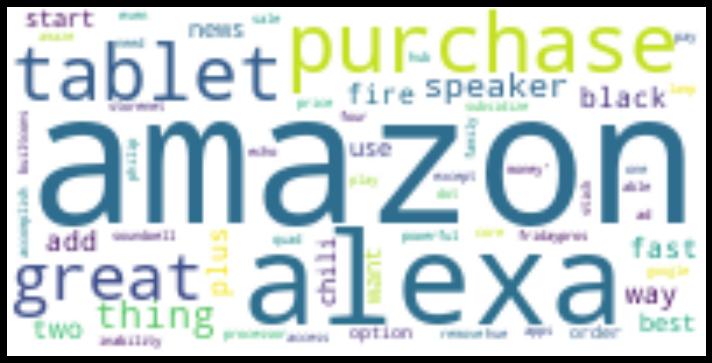

In [127]:
from wordcloud import WordCloud,STOPWORDS
text = train_data['preprocessed_reviews'].values
wc = WordCloud(width=200,height=100,stopwords=STOPWORDS,background_color='white').generate(str(text))
fig = plt.figure(figsize=(10,10),facecolor='k',edgecolor='w')
plt.imshow(wc,interpolation='bilinear')
plt.axis('off')
plt.tight_layout()
plt.show()

<h1>The End</h1>